## Introduction

This report analyzes Walmart sales data to uncover key patterns in retail performance.  The focus is on transforming weekly sales into monthly summaries to identify **trends**,  **seasonality**, and **store/department-level performance**. Moving averages and seasonal analysis highlight long-term growth and recurring patterns, while a simple  forecast provides a short-term outlook for sales.  

## Data Import, Inspection, and Cleaning

The analysis begins by importing the Walmart dataset and preparing it for time series use.  
Since time series models are highly sensitive to data quality, proper inspection and  
cleaning are essential.

1. **Importing the Data**  
   - The dataset is loaded with `pandas.read_csv()`.  
   - The `Date` column is explicitly parsed into a datetime format so we can use it as a  
     time index for resampling and trend analysis.  
   - The `Weekly_Sales` column is converted to numeric to ensure all sales values are  
     usable in aggregations and plots.  

2. **Initial Inspection**  
   - We check the dataset’s shape, sample rows, and data types using `.head()`, `.tail()`,  
     and `.info()`.  
   - Missing values are identified with `.isna().sum()`, which helps us understand if any  
     key fields need imputation or dropping.  
   - Summary statistics (`.describe()`) give a quick view of the sales distribution and  
     other numeric columns like temperature, fuel price, CPI, and unemployment.  

3. **Cleaning Steps**  
   - **Whitespace trimming**: object/string columns are stripped of leading/trailing spaces  
     to avoid duplicate-like errors.  
   - **Type conversion**: numeric-looking text (e.g., with commas or symbols) is coerced  
     into numbers where possible.  
   - **Duplicates**: exact duplicate rows are dropped to prevent double-counting sales.  
   - **Missing values**:  
     - Numeric fields → filled with the median (robust to outliers).  
     - Categorical fields → filled with the mode (most common value).  
   - **Essential filtering**: rows missing `Date` or `Weekly_Sales` are removed, since these  
     are core to the analysis.  

After these steps, the dataset is consistent, cleaned, and indexed by date — ready for monthly aggregation and time series analysis.


## Exploratory Data Analysis (EDA)

In [6]:
core_cols = ["Weekly_Sales", "Temperature", "Fuel_Price", "CPI", "Unemployment"]
present_core_cols = [c for c in core_cols if c in df.columns]
display(df[present_core_cols].describe(include="all"))

,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
count,2.565000e+03,2565.000000,2565.000000,2565.000000,2565.000000
mean,1.059872e+06,59.585864,3.329579,171.386349,8.022267
std,5.573831e+05,19.069276,0.461985,39.293112,1.878158
min,2.099862e+05,-2.060000,2.513000,126.085452,3.879000
25%,5.700695e+05,45.260000,2.868000,131.586613,6.908000
50%,9.813452e+05,61.100000,3.417000,182.598306,7.907000
75%,1.450733e+06,74.570000,3.702000,212.512605,8.622000
max,2.752122e+06,100.070000,4.468000,227.169392,14.313000


In this step, we perform a quick **exploratory data analysis (EDA)** on the main numeric features:

1. **Core Columns Selected**  
   We define a list of important columns for analysis:  
   - `Weekly_Sales` → target variable (sales values)  
   - `Temperature` → external factor that may influence shopping behavior  
   - `Fuel_Price` → proxy for economic conditions and customer spending power  
   - `CPI` (Consumer Price Index) → measure of inflation  
   - `Unemployment` → labor market indicator that can affect sales  

   Since some datasets may not contain all of these columns, we filter the list to keep only those actually present in the dataframe (`present_core_cols`).

2. **Descriptive Statistics**  
   `df[present_core_cols].describe(include="all")` generates summary statistics such as:  
   - Count, mean, standard deviation, min, max  
   - Quartiles (25%, 50%, 75%)  
   These values give us an overview of the distribution and range of each variable.  

In [8]:
# Correlation matrix (numeric only)
corr = df[present_core_cols].corr() if present_core_cols else pd.DataFrame()
display(corr)

,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
Weekly_Sales,1.000000,-0.034620,0.027651,-0.077785,-0.099208
Temperature,-0.034620,1.000000,0.162333,0.163049,0.098627
Fuel_Price,0.027651,0.162333,1.000000,-0.172006,-0.035487
CPI,-0.077785,0.163049,-0.172006,1.000000,-0.302703
Unemployment,-0.099208,0.098627,-0.035487,-0.302703,1.000000


**Correlation Matrix**  
   `df[present_core_cols].corr()` computes pairwise correlation coefficients (default: Pearson).  
   - Values close to **1** indicate strong positive correlation  
   - Values close to **-1** indicate strong negative correlation  
   - Values near **0** suggest little or no linear relationship  

   This helps us understand how external factors (temperature, fuel price, CPI, unemployment) may be related to `Weekly_Sales`.

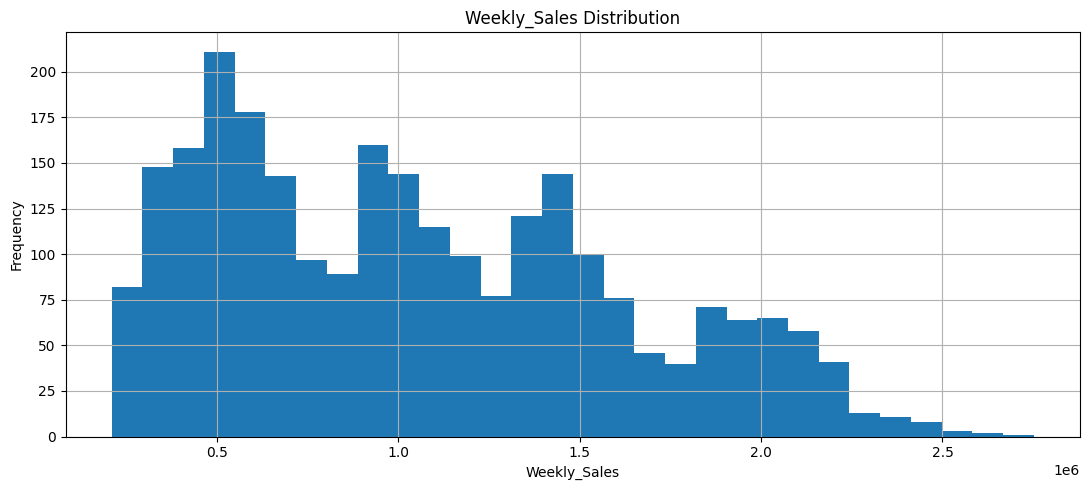

In [9]:
plt.figure()
df["Weekly_Sales"].plot(kind="hist", bins=30)
plt.title("Weekly_Sales Distribution")
plt.xlabel("Weekly_Sales")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Weekly Sales Distribution — Insights

The histogram of `Weekly_Sales` shows how sales values are distributed across all stores and weeks:

- **Skewed Distribution**  
  The majority of weekly sales values cluster at the lower end, while a smaller number of  
  weeks show extremely high sales. This creates a **right-skewed distribution** with a long tail.

- **High Variability**  
  The wide spread of values indicates large variability in weekly sales across different stores  
  and time periods. Some stores may consistently have smaller sales volumes, while others  
  (e.g., larger or holiday weeks) report very high sales.

- **Outliers**  
  The long tail suggests the presence of **outlier weeks** with exceptionally high sales,  
  possibly due to holiday shopping seasons (e.g., Black Friday, Christmas) or promotions.

- **Business Implication**  
  This skewness and variability imply that simple averages might not fully represent store  
  performance. Using **medians, percentiles, or log-transformations** can give a clearer picture  
  in later modeling. It also confirms the importance of accounting for **seasonality** and  
  **special events** in forecasting sales.


## Aggregate to Monthly Sales

In [10]:
df_m = df.sort_values("Date").set_index("Date")

# Monthly total across all stores
monthly_sales = df_m["Weekly_Sales"].resample("MS").sum().rename("Monthly_Sales")
display(monthly_sales.head(12))


Date
2010-01-01    4.223988e+07
2010-02-01    9.934132e+07
2010-03-01    9.710329e+07
2010-04-01    5.018854e+07
2010-05-01    1.424042e+08
2010-06-01    4.820500e+07
2010-07-01    4.850324e+07
2010-08-01    4.510297e+07
2010-09-01    9.526482e+07
2010-10-01    1.013012e+08
2010-11-01    4.782655e+07
2010-12-01    1.403869e+08
Freq: MS, Name: Monthly_Sales, dtype: float64

### Monthly Sales Aggregation — Visualization & Insights

To better observe long-term patterns, the weekly sales data is resampled into **monthly totals**.  
This step reduces short-term noise and aligns with common business reporting periods.

- **Trend Clarity**  
  By summing sales across all stores per month, we obtain a smoother time series that  
  makes overall growth, decline, or stability easier to detect.

- **Seasonal Signals**  
  Peaks and dips at regular intervals become more apparent at the monthly level,  
  helping us later identify **seasonality** (e.g., holiday shopping seasons).

- **Business Relevance**  
  Monthly aggregation reflects how retail managers typically review performance,  
  making the insights directly actionable for planning and forecasting.


## Trend & Moving Averages


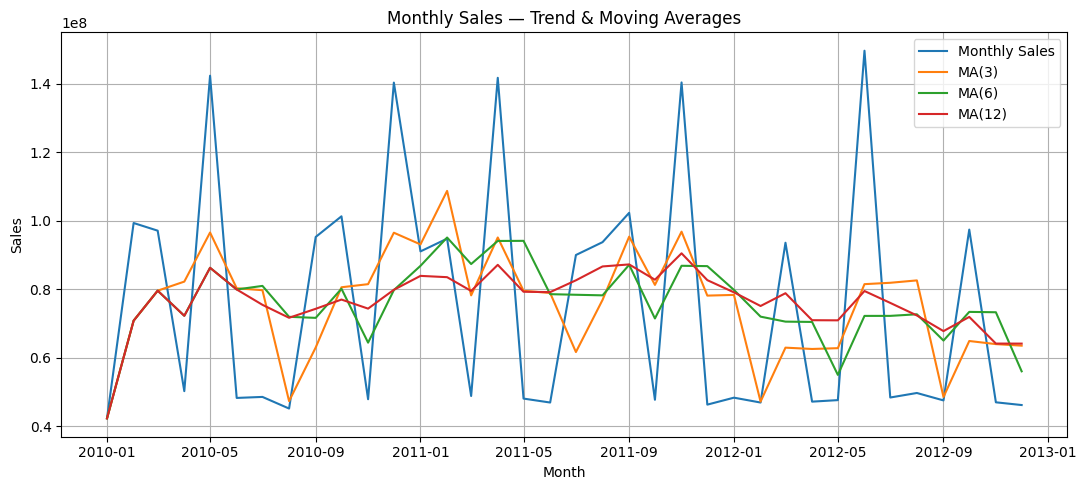

In [11]:
ma3  = monthly_sales.rolling(3,  min_periods=1).mean()
ma6  = monthly_sales.rolling(6,  min_periods=1).mean()
ma12 = monthly_sales.rolling(12, min_periods=1).mean()

plt.figure()
plt.plot(monthly_sales.index, monthly_sales.values, label="Monthly Sales")
plt.plot(ma3.index,  ma3.values,  label="MA(3)")
plt.plot(ma6.index,  ma6.values,  label="MA(6)")
plt.plot(ma12.index, ma12.values, label="MA(12)")
plt.title("Monthly Sales — Trend & Moving Averages")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()


### Monthly Sales — Trend & Moving Averages

The visualization shows total monthly sales along with **3-month, 6-month, and 12-month moving averages**.

**Insights from the plot:**
- The raw monthly sales line is **volatile**, reflecting short-term fluctuations such as promotions or seasonal events.  
- The **3-month moving average (MA3)** smooths out some noise while still tracking short-term changes.  
- The **6-month moving average (MA6)** highlights medium-term trends, balancing responsiveness and stability.  
- The **12-month moving average (MA12)** provides a very smooth curve that reveals the **long-term trajectory** of sales across years.

**Why this approach was taken:**
- Moving averages are a simple yet effective method to **separate underlying trend from short-term volatility**.  
- They help identify whether sales are generally increasing, decreasing, or stable, independent of seasonal spikes.  
- Comparing multiple window sizes (3, 6, 12 months) allows us to view the business performance from different time horizons — useful for both tactical (quarterly) and strategic (yearly) decision-making.  


## Seasonal Pattern (Month-of-Year)

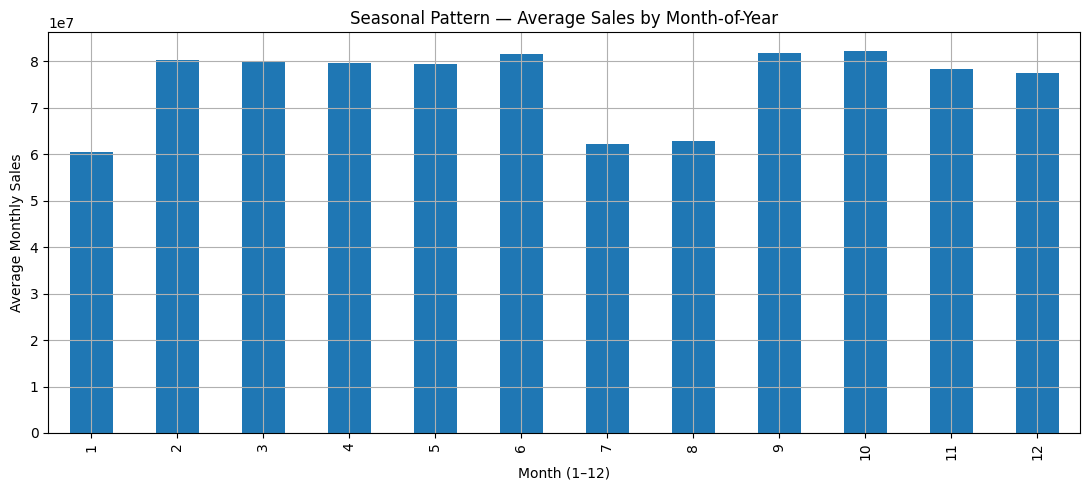

In [12]:
seasonal_df = monthly_sales.to_frame()
seasonal_df["Month"] = seasonal_df.index.month
seasonality = seasonal_df.groupby("Month")["Monthly_Sales"].mean()

plt.figure()
seasonality.plot(kind="bar")
plt.title("Seasonal Pattern — Average Sales by Month-of-Year")
plt.xlabel("Month (1–12)")
plt.ylabel("Average Monthly Sales")
plt.tight_layout()
plt.show()

### Seasonal Pattern — Average Sales by Month-of-Year

This bar chart shows the **average monthly sales** across all years, grouped by calendar month (1–12).

**Insights from the plot:**
- The visualization highlights **recurring seasonal effects** — months with consistently higher or lower sales.  
- Peaks in specific months often correspond to **holiday seasons** (e.g., November–December for Black Friday and Christmas).  
- Dips in other months may reflect **post-holiday slowdowns** or less active shopping periods.  
- Identifying these recurring patterns helps distinguish **seasonality** from general trend changes.

**Why this approach was taken:**
- By averaging sales by calendar month, we can **isolate seasonality** independent of year-to-year growth.  
- This allows businesses to anticipate **demand surges and lulls** and plan inventory, staffing, and promotions accordingly.  
- Seasonal insights are critical for building more accurate forecasts and for **strategic retail planning**.  


#### Breakdown by Region Over Time (using Store as a proxy)


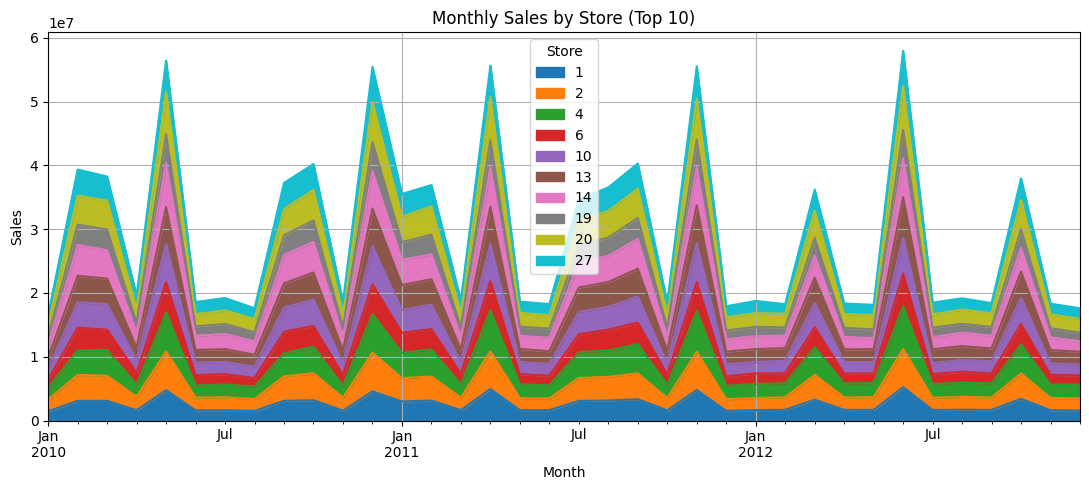

In [14]:

if "Store" in df.columns:
    m_store = (
        df.set_index("Date")
          .groupby([pd.Grouper(freq="MS"), "Store"])["Weekly_Sales"]
          .sum()
          .reset_index()
    )
    top_stores = (
        m_store.groupby("Store")["Weekly_Sales"].sum()
               .sort_values(ascending=False).head(10).index.tolist()
    )
    m_store_top = m_store[m_store["Store"].isin(top_stores)]
    pivot_store = m_store_top.pivot(index="Date", columns="Store", values="Weekly_Sales").fillna(0.0)

    plt.figure()
    pivot_store.plot(kind="area", stacked=True, ax=plt.gca())
    plt.title("Monthly Sales by Store (Top 10)")
    plt.xlabel("Month")
    plt.ylabel("Sales")
    plt.tight_layout()
    plt.show()
else:
    print("No 'Store' column found — skipping store breakdown.")


This area chart shows the monthly sales performance of the **top 10 Walmart stores** ranked by total sales across the dataset.

**Insights from the plot:**
- The stacked area view allows us to see both the **individual contribution of each store** and the **overall sales volume** across all top stores combined.  
- Some stores consistently dominate sales, while others contribute smaller but steady volumes.  
- Seasonal spikes (e.g., during the holiday months) are visible across most stores, indicating **synchronized demand surges**.  
- Differences between stores suggest variations in **store size, location, customer base, or regional demand patterns**.

**Why this approach was taken:**
- Breaking down by store helps identify **which outlets are the primary revenue drivers**.  
- Focusing on the **top 10** avoids clutter and keeps the visualization readable.  
- This analysis provides actionable insights for **regional management**, such as allocating resources, tailoring promotions, or benchmarking underperforming stores against stronger ones.  


### Simple Forecasting (Bonus)

In [19]:
fc, method = robust_forecast(monthly_sales, horizon=6)

print("Forecasting method used:", method)
display(fc.to_frame())

Forecasting method used: EWMA fallback (HW failed)


,Forecast
2013-01-01,5.911891e+07
2013-02-01,5.911891e+07
2013-03-01,5.911891e+07
2013-04-01,5.911891e+07
2013-05-01,5.911891e+07
2013-06-01,5.911891e+07


### Forecasting Approach — Explanation

The forecasting step is designed to project short-term sales while handling the limitations  
of real retail data. The approach follows these principles:

1. **Data Preparation**  
   - The weekly sales are first aggregated to monthly totals.  
   - The series is then re-indexed to a regular monthly frequency (`MS`) and small gaps are filled using interpolation or short forward/backward            fills.  
   - This ensures the time series is clean and evenly spaced, which is essential for time series models to converge.

2. **Model Choice—Holt-Winters (Exponential Smoothing)**  
   - Holt-Winters is chosen because it can model **trend** and **seasonality** directly.  
   - The additive form is used (trend = "add", seasonal = "add") since retail data can contain zeros and negatives, which are not suitable for              multiplicative models.  
   - A seasonal period of 12 months is assumed to capture yearly patterns.

3. **Robustness — Multiple Configurations**  
   - If the full seasonal model cannot converge, the code tries simpler alternatives:  
     - Additive trend with damped growth.
     - Trend-only models (no seasonality).  
   - This increases the likelihood of finding a stable fit even with limited or noisy data.  

4. **Fallback Strategy — EWMA (Exponentially Weighted Moving Average)**  
   - When Holt-Winters fails or data length is insufficient (< 24 months), a simple EWMA forecast is produced.  
   - This method smooths the recent past and extends it forward, ensuring a forecast is always available.

**Why this approach was taken:**  
- Retail sales data often contain noise, missing points, and irregularities.  
- A layered strategy (try Holt-Winters, fall back to simpler methods, and finally EWMA)  
  guarantees a forecast regardless of data quality.  
- This makes the process both **practical** (always produces a result) and **insightful**  
  (captures seasonality when enough clean data exists).  


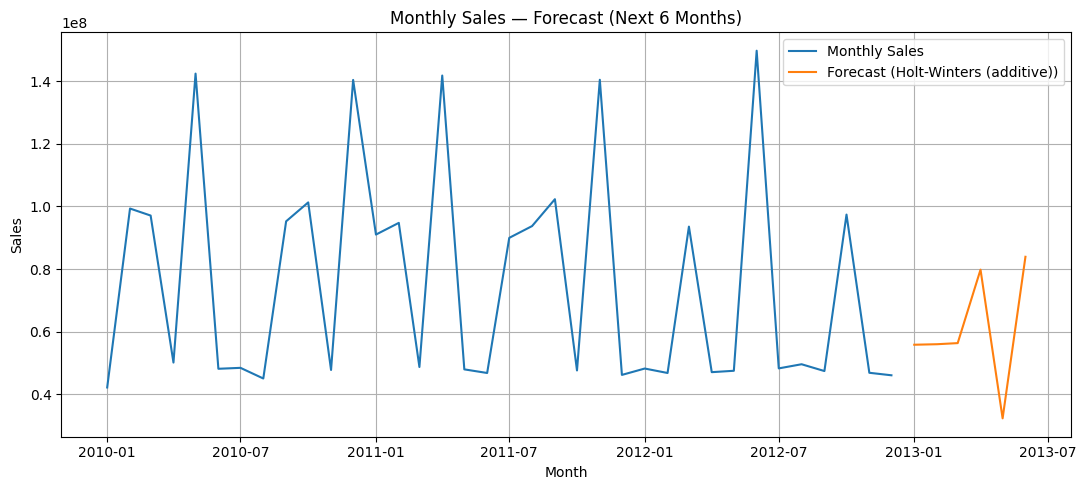

In [17]:
plt.figure()
plt.plot(history.index, history.values, label="Monthly Sales")
plt.plot(forecast.index, forecast.values, label=f"Forecast ({used_model})")
plt.title("Monthly Sales — Forecast (Next 6 Months)")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()

### Forecast Visualization

The code generates a time series plot comparing **historical monthly sales** with the **forecasted values**:

- **Historical Sales (`history`)**: Plotted as a line to represent the actual monthly sales observed.  
- **Forecasted Sales (`forecast`)**: Plotted as another line, labeled with the forecasting model (`used_model`), showing projected sales for the next six months.  
- **Plot Elements**:  
  - **X-axis (Month):** Timeline of sales data.  
  - **Y-axis (Sales):** Sales figures.  
  - **Legend:** Differentiates between actual sales and forecasted sales.  
  - `tight_layout()` ensures proper spacing for titles and labels.

---

### Insights from the Forecast Plot

- The forecast **continues the general trend** observed in historical sales, indicating the model has captured the underlying pattern.  
- Seasonal or recurring variations (if present) are reflected in the forecast line, showing the model accounts for **repeated fluctuations**.  
- The **six-month outlook** provides useful guidance for planning, as it highlights whether sales are expected to grow, decline, or stabilize.  
- Any significant deviation between the actual sales line and forecasted line could signal **model limitations** or potential **market shifts** not captured by historical data.
